<a href="https://colab.research.google.com/github/wilsonfmjr/PPGEEC2321---REDES-NEURAIS-E-DEEP-LEARNING/blob/main/Questao_4a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importação de bibliotecas

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

#Geração da série temporal

In [ ]:
# ---------- Gerar série temporal ----------
def gerar_serie(N, beta=0.5):
    np.random.seed(42)                 # Define a seed (o valor que você quer usar como ponto de partida)
    v = np.random.normal(0, 1, N)      # Ruído branco gaussiano (média 0, variância 1)
    x = np.zeros(N)                    # Inicializa a série x com zeros
    for n in range(2, N):              # Começa de n=2 porque usa v[n-1] e v[n-2]
        x[n] = v[n] + beta * v[n-1] * v[n-2]
    return x

#Preparação dos dados com janelas de atraso

In [ ]:
# ---------- Preparar dados ----------
def preparar_dados(serie, ordem):
    X = []                              # Lista para as entradas
    Y = []                              # Lista para as saídas (alvo)
    for i in range(ordem, len(serie)-1):
        X.append(serie[i-ordem:i])       # Coleta os 'ordem' atrasos
        Y.append(serie[i+1])             # Saída é x(n+1)
    X = np.array(X)                      # Converte para array numpy
    Y = np.array(Y)
    return X, Y

#Definição da Rede Neural (MLP)

In [ ]:
# ---------- Definir MLP ----------
class NARX_MLP(nn.Module):
    def __init__(self, ordem, hidden_size):
        super(NARX_MLP, self).__init__()            # Inicializa classe mãe
        self.net = nn.Sequential(                   # Rede sequencial:
            nn.Linear(ordem, hidden_size),          # Camada de entrada
            nn.ReLU(),                              # Função de ativação: ReLU

            nn.Linear(hidden_size, hidden_size),    # Camada oculta
            nn.ReLU(),                              # Função de ativação: ReLU

            nn.Linear(hidden_size, hidden_size),    # Camada oculta
            nn.ReLU(),                              # Função de ativação: ReLU

            nn.Linear(hidden_size, hidden_size),    # Camada oculta
            nn.ReLU(),                              # Função de ativação: ReLU

            nn.Linear(hidden_size, hidden_size),    # Camada oculta
            nn.ReLU(),                              # Função de ativação: ReLU

            nn.Linear(hidden_size, 1)               # Camada de saída
        )

    def forward(self, x):                       # Método para propagação direta
        return self.net(x).squeeze()            # Remove dimensões extras

#Configuração dos Parâmetros

In [ ]:
# ---------- Parâmetros ----------
N = 1000                     # Tamanho da série temporal
ordem = 5                   # Número de atrasos (lags) na entrada
hidden_size = 500             # Neurônios na camada oculta
beta = 0.5                   # Parâmetro do modelo da série

#Geração dos dados

In [ ]:
serie = gerar_serie(N, beta)                   # Gera a série temporal
X, Y = preparar_dados(serie, ordem)             # Cria pares entrada/saída

#Dividir em treino e teste

In [ ]:
train_size = int(N*0.7)                               # 70% para treino, restante para teste
X_train = torch.tensor(X[:train_size], dtype=torch.float32)
Y_train = torch.tensor(Y[:train_size], dtype=torch.float32)
X_test = torch.tensor(X[train_size:], dtype=torch.float32)
Y_test = torch.tensor(Y[train_size:], dtype=torch.float32)

#Instanciando o modelo, a função de custo e otimizador

In [ ]:
# ---------- Modelo ----------
model = NARX_MLP(ordem, hidden_size)          # Instancia o modelo
criterion = nn.MSELoss()                      # Erro quadrático médio
optimizer = optim.Adam(model.parameters(), lr=0.01) # Otimizador Adam

#Treinamento do modelo

🛑 Treinamento interrompido na época 1003 pois Loss < 0.0001


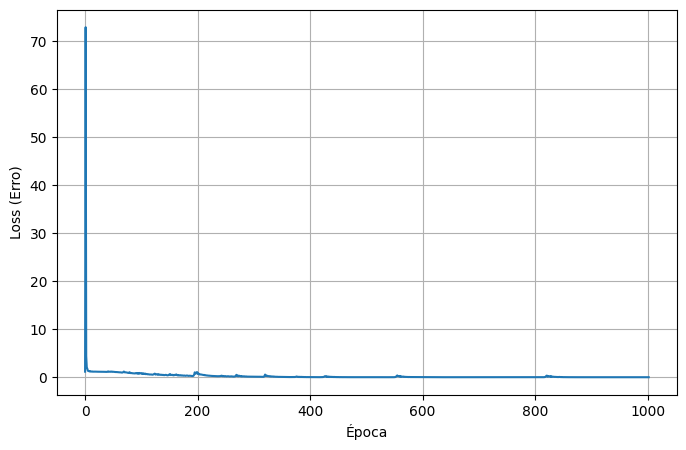

In [ ]:
# ---------- Treinamento ----------
loss_history = []                               # Lista para armazenar o loss por epoch
epochs = 6000
for epoch in range(epochs):
    model.train()                               # Modo treino
    optimizer.zero_grad()                       # Zera os gradientes anteriores
    output = model(X_train)                     # Predição no treino
    loss = criterion(output, Y_train)           # Calcula o erro
    loss.backward()                             # Backpropagation
    optimizer.step()                            # Atualiza os pesos

    # if (epoch+1) % 50 == 0:                     # Mostra o erro a cada 50 épocas
    #     print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    loss_history.append(loss.item())  # 🔥 Salva o loss da época atual

        # Parada antecipada:
    if loss.item() < 0.0001:
        print(f'🛑 Treinamento interrompido na época {epoch+1} pois Loss < 0.0001')
        break

plt.figure(figsize=(8,5))
plt.plot(loss_history)#, marker='o')
# plt.title('Curva do Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss (Erro)')
plt.grid(True)
plt.show()

#Avaliação no conjunto de teste

In [ ]:
# ---------- Avaliação ----------
model.eval()                                   # Modo avaliação (desativa dropout/batchnorm)
with torch.no_grad():                          # Sem cálculo de gradientes
    Y_pred = model(X_test)                     # Predição no teste

#Cálculo do erro

In [ ]:
# ---------- Cálculo do erro ----------
erro = Y_test.numpy() - Y_pred.numpy()

#Plotagem dos resultados

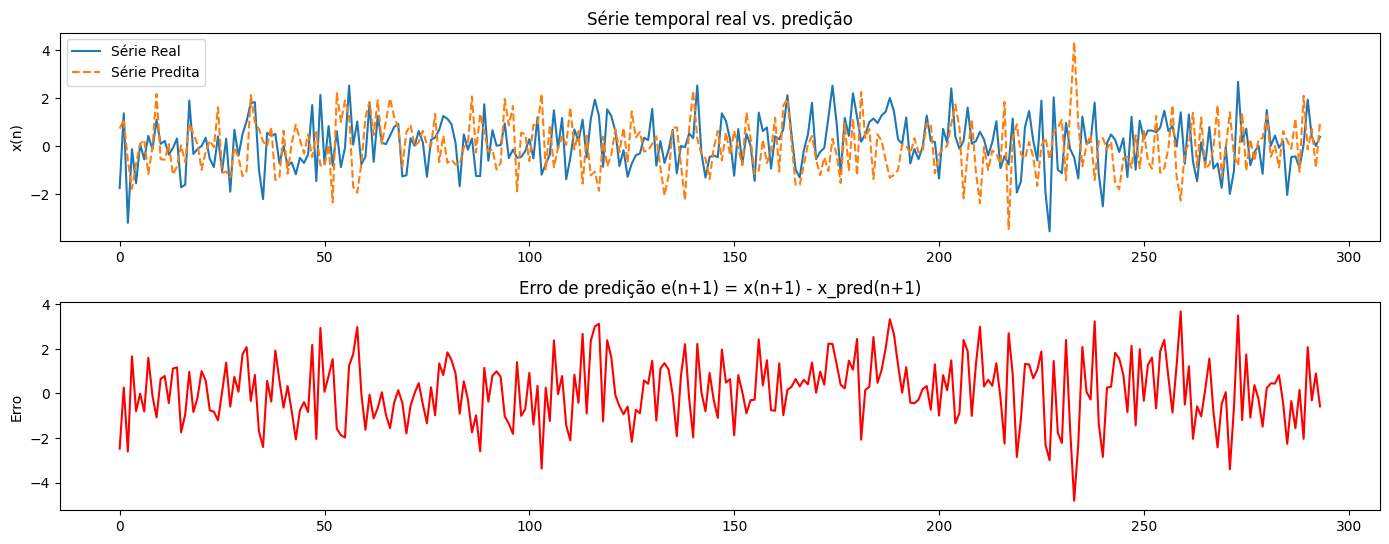

In [ ]:
# ---------- Plot ----------
plt.figure(figsize=(14, 8))

# Série temporal real e predita
plt.subplot(3,1,1)
plt.plot(Y_test.numpy(), label='Série Real')
plt.plot(Y_pred.numpy(), label='Série Predita', linestyle='--')
plt.title('Série temporal real vs. predição')
plt.ylabel('x(n)')
plt.legend()

# Erro de predição
plt.subplot(3,1,2)
plt.plot(erro, color='red')
plt.title('Erro de predição e(n+1) = x(n+1) - x_pred(n+1)')
plt.ylabel('Erro')

plt.tight_layout()
plt.show()